In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip
  
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation-horse-or-human')
zip_ref.close()

# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

# Directory with our training horse pictures
validation_horse_dir = os.path.join('/tmp/validation-horse-or-human/horses')

# Directory with our training human pictures
validation_human_dir = os.path.join('/tmp/validation-horse-or-human/humans')

--2019-11-08 09:40:12--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 2a00:1450:400c:c0b::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   118MB/s    in 1.2s    

2019-11-08 09:40:13 (118 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2019-11-08 09:40:16--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.140.128, 2a00:1450:400c:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.140.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/z

## Building a Small Model from Scratch

But before we continue, let's start defining the model:

Step 1 will be to import tensorflow.

In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

We then add convolutional layers as in the previous example, and flatten the final result to feed into the densely connected layers.

Finally we add the densely connected layers. 

Note that because we are facing a two-class classification problem, i.e. a *binary classification problem*, we will end our network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function), so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [0]:
l1 = tf.keras.regularizers.l1
l2 = tf.keras.regularizers.l2

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color

    # This is the first convolution
    tf.keras.layers.Conv2D(
        16, (3,3), 
        activation='relu', 
        input_shape=(300, 300, 3),
        #activity_regularizer=l2(0.01)
        ),
    tf.keras.layers.MaxPooling2D(2, 2),
    # tf.keras.layers.Dropout(0.1),

    # The second convolution
    tf.keras.layers.Conv2D(
        32, (3,3), 
        activation='relu',
        #activity_regularizer=l2(0.01)
        ),
    tf.keras.layers.MaxPooling2D(2,2),
    # tf.keras.layers.Dropout(0.1),

    # The third convolution
    tf.keras.layers.Conv2D(
        64, (3,3), 
        activation='relu',
        #activity_regularizer=l2(0.01)
        ),
    tf.keras.layers.MaxPooling2D(2,2),
    # tf.keras.layers.Dropout(0.1),

    # The fourth convolution
    tf.keras.layers.Conv2D(
        64, (3,3), 
        activation='relu',
        #activity_regularizer=l2(0.01)
        ),
    tf.keras.layers.MaxPooling2D(2,2),
    # tf.keras.layers.Dropout(0.1),

    # The fifth convolution
    tf.keras.layers.Conv2D(
        64, (3,3), 
        activation='relu',
        #activity_regularizer=l2(0.05)
        ),
    tf.keras.layers.MaxPooling2D(2,2),
    # tf.keras.layers.Dropout(0.2),
    
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(
        512, 
        activation='relu',
        activity_regularizer=l2(0.01)
        ),
    tf.keras.layers.Dropout(0.2),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

In [146]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 33, 33, 64)      

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

In [148]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
                    rescale=1./255.,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255.)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                      '/tmp/horse-or-human/',  # This is the source directory for training images
                      target_size=(300, 300),  # All images will be resized to 150x150
                      batch_size=128,
                      class_mode='binary') # Since we use binary_crossentropy loss, we need binary labels

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
                          '/tmp/validation-horse-or-human/',  # This is the source directory for training images
                          target_size=(300, 300),  # All images will be resized to 150x150
                          batch_size=32,
                          class_mode='binary') # Since we use binary_crossentropy loss, we need binary labels

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [0]:
history = {}

In [150]:
 for i in range(50):
  tmp = model.fit_generator(
              train_generator,
              steps_per_epoch=8,  
              epochs=2,
              verbose=2,
              validation_data=validation_generator,
              validation_steps=8)

  if not history:
    history = tmp
  else: 
    history.history['acc'] += tmp.history['acc']
    history.history['val_acc'] += tmp.history['val_acc']
    history.history['loss'] += tmp.history['loss']
    history.history['val_loss'] += tmp.history['val_loss']


Epoch 1/2
Epoch 1/2
8/8 - 2s - loss: 0.6620 - acc: 0.8281
8/8 - 26s - loss: 0.6915 - acc: 0.5662 - val_loss: 0.6620 - val_acc: 0.8281
Epoch 2/2
Epoch 1/2
8/8 - 1s - loss: 0.6591 - acc: 0.5391
8/8 - 24s - loss: 0.6784 - acc: 0.6129 - val_loss: 0.6591 - val_acc: 0.5391
Epoch 1/2
Epoch 1/2
8/8 - 1s - loss: 0.5981 - acc: 0.7695
8/8 - 26s - loss: 0.6503 - acc: 0.6618 - val_loss: 0.5981 - val_acc: 0.7695
Epoch 2/2
Epoch 1/2
8/8 - 2s - loss: 0.6970 - acc: 0.5898
8/8 - 27s - loss: 0.6185 - acc: 0.7305 - val_loss: 0.6970 - val_acc: 0.5898
Epoch 1/2
Epoch 1/2
8/8 - 1s - loss: 0.7382 - acc: 0.6406
8/8 - 29s - loss: 0.5925 - acc: 0.7275 - val_loss: 0.7382 - val_acc: 0.6406
Epoch 2/2
Epoch 1/2
8/8 - 1s - loss: 0.6821 - acc: 0.7422
8/8 - 22s - loss: 0.5499 - acc: 0.7739 - val_loss: 0.6821 - val_acc: 0.7422
Epoch 1/2
Epoch 1/2
8/8 - 2s - loss: 0.8140 - acc: 0.6758
8/8 - 26s - loss: 0.5610 - acc: 0.7853 - val_loss: 0.8140 - val_acc: 0.6758
Epoch 2/2
Epoch 1/2
8/8 - 1s - loss: 1.0434 - acc: 0.6094
8/8 

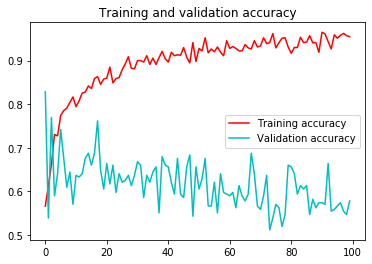

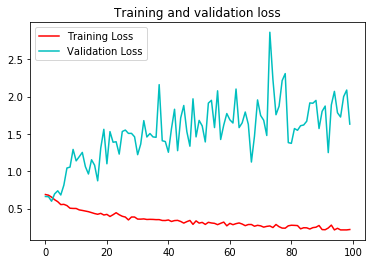

In [151]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'c', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'c', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()